# Capstone project notebook

## Problem 3

### What Is the Relationship between Housing Characteristics and Complaints?
The goal of this exercise is to find the answer to the Question 3 of the problem statement: 

### Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

In this exercise, use the 311 dataset.

You also need to read back the PLUTO dataset from Cloud Object Store that you saved previously in the course. Use the PLUTO dataset for the borough that you already identified to focus on the last exercise.Ensure that you use only a limited number of fields from the dataset so that you are not consuming too much memory during your analysis.

The recommended fields are Address, BldgArea, BldgDepth, BuiltFAR, CommFAR, FacilFAR, Lot, LotArea, LotDepth, NumBldgs, NumFloors, OfficeArea, ResArea, ResidFAR, RetailArea, YearBuilt, YearAlter1, ZipCode, YCoord, and XCoord.

In [1]:
# The code was removed by Watson Studio for sharing.

,address_type,borough,city,closed_date,complaint_type,created_date,incident_address,incident_zip,latitude,location_type,longitude,resolution_description,status,street_name,unique_key
0,ADDRESS,BRONX,BRONX,2018-04-24T14:15:01.000,GENERAL,2017-12-12T10:05:40.000,383 EAST 162 STREET,10451.0,40.824952,RESIDENTIAL BUILDING,-73.913944,The Department of Housing Preservation and Dev...,Closed,EAST 162 STREET,37914383
1,ADDRESS,BRONX,BRONX,2018-04-24T14:15:02.000,GENERAL,2018-01-08T12:47:29.000,383 EAST 162 STREET,10451.0,40.824952,RESIDENTIAL BUILDING,-73.913944,The Department of Housing Preservation and Dev...,Closed,EAST 162 STREET,38152033
2,ADDRESS,QUEENS,Woodside,2018-04-24T21:29:42.000,PAINT/PLASTER,2018-01-08T22:33:51.000,60-10 47 AVENUE,11377.0,40.739912,RESIDENTIAL BUILDING,-73.904328,The Department of Housing Preservation and Dev...,Closed,47 AVENUE,38157143
3,ADDRESS,QUEENS,Astoria,2018-04-24T09:50:17.000,APPLIANCE,2018-01-12T17:09:03.000,34-15 31 STREET,11106.0,40.759282,RESIDENTIAL BUILDING,-73.927550,The Department of Housing Preservation and Dev...,Closed,31 STREET,38205215
4,ADDRESS,QUEENS,Astoria,2018-04-24T09:50:18.000,DOOR/WINDOW,2018-01-22T14:04:15.000,30-34 32 STREET,11102.0,40.765523,RESIDENTIAL BUILDING,-73.921410,The Department of Housing Preservation and Dev...,Closed,32 STREET,38275095


### Read Bronx file

To prevent loading unnecesary data, we select the columns to load

In [2]:
body = client_cba83a820ee941cd921cc2bbfefd15eb.get_object(Bucket='edx1-donotdelete-pr-ffppmpbmudcobi',Key='bronxs.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
cols_to_read = [  'Address',
                  'BldgArea',
                  'BldgDepth',
                  'BuiltFAR',
                  'CommFAR',
                  'FacilFAR',
                  'Lot', 
                  'LotArea',
                  'LotDepth',
                  'NumBldgs',
                  'NumFloors',
                  'OfficeArea',
                  'ResArea',
                  'ResidFAR',
                  'RetailArea',
                  'YearBuilt',
                  'YearAlter1',
                  'ZipCode',
                  'YCoord',
                  'XCoord']
df_bronx_info = pd.read_csv(body, usecols=cols_to_read)

In [3]:
df_bronx_info.head()

,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


### We create a subset pandas dataframe

With only the values to study, namely borough, address and location. After that we make and encoding setting BRONX as 1 and all others as 0


In [4]:
df_bronx_incidents = df_311[['complaint_type', 'incident_address', 'latitude', 'longitude', 'unique_key']].loc[df_311['borough'] == 'BRONX']
print('Number of Bronx incidents',df_bronx_incidents['unique_key'].count(),sep=' ')
df_bronx_incidents.head()

Number of Bronx incidents 1508988


,complaint_type,incident_address,latitude,longitude,unique_key
0,GENERAL,383 EAST 162 STREET,40.824952,-73.913944,37914383
1,GENERAL,383 EAST 162 STREET,40.824952,-73.913944,38152033
6,PAINT/PLASTER,2647 SEDGWICK AVENUE,40.869502,-73.904438,38278432
9,WATER LEAK,2647 SEDGWICK AVENUE,40.869502,-73.904438,38279902
10,WATER LEAK,2647 SEDGWICK AVENUE,40.869502,-73.904438,38281075


In [5]:
df_bronx_incidents['complaint_type'] = (df_bronx_incidents['complaint_type'] == 'HEAT/HOT WATER').astype(int)

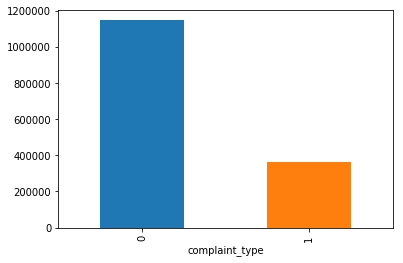

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
df_bronx_incidents.groupby('complaint_type').agg('complaint_type').count().plot.bar()

### We need to join incidents with building information

A left inner join is what we need

In [7]:
df_bronx = pd.merge(df_bronx_incidents, df_bronx_info, how='left', left_on=['incident_address'], right_on=['Address'])

In [8]:
print('Number of Bronx incidents and building information',df_bronx['unique_key'].count(),sep=' ')

Number of Bronx incidents and building information 1510149


### There are incident streets not available in the pluto file, so we just drop them

This is a problem with cardinality.

In [9]:
df_bronx.dropna(inplace=True)

### Let's get rid of the addresses

Let's see how many null values we have in the dataframe, and then eliminate them. Also we can select Lot as the index

In [10]:
df_bronx.drop(['Address', 'incident_address'], axis=1, inplace=True)

### Eliminate duplicates

There are a lot of duplicates. We are cleaning them and it results in *_1,211,609_* rows

In [11]:
df_bronx.drop_duplicates(inplace=True)

In [12]:
print('Number of Bronx incidents with no duplicates',df_bronx['unique_key'].count(),sep=' ')

Number of Bronx incidents with no duplicates 1211609


### Let's define dependant and independant variables

In [13]:
import numpy as np

y = np.asarray(df_bronx['complaint_type'])
predictors = df_bronx.columns.difference(['complaint_type'])
X = df_bronx[predictors]
X.set_index('unique_key', inplace=True)

In [14]:
X.head(10)

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,...,ResArea,ResidFAR,RetailArea,XCoord,YCoord,YearAlter1,YearBuilt,ZipCode,latitude,longitude
unique_key,,,,,,,,,,,,,,,,,,,,,
38278432,27225.0,90.0,4.54,0.0,4.8,100.0,6003.0,121.83,1.0,5.0,...,25225.0,2.43,2000.0,1010691.0,256196.0,0.0,1924.0,10468.0,40.869502,-73.904438
38279902,27225.0,90.0,4.54,0.0,4.8,100.0,6003.0,121.83,1.0,5.0,...,25225.0,2.43,2000.0,1010691.0,256196.0,0.0,1924.0,10468.0,40.869502,-73.904438
38281075,27225.0,90.0,4.54,0.0,4.8,100.0,6003.0,121.83,1.0,5.0,...,25225.0,2.43,2000.0,1010691.0,256196.0,0.0,1924.0,10468.0,40.869502,-73.904438
38282465,27225.0,90.0,4.54,0.0,4.8,100.0,6003.0,121.83,1.0,5.0,...,25225.0,2.43,2000.0,1010691.0,256196.0,0.0,1924.0,10468.0,40.869502,-73.904438
38282492,27225.0,90.0,4.54,0.0,4.8,100.0,6003.0,121.83,1.0,5.0,...,25225.0,2.43,2000.0,1010691.0,256196.0,0.0,1924.0,10468.0,40.869502,-73.904438
38347558,27225.0,90.0,4.54,0.0,4.8,100.0,6003.0,121.83,1.0,5.0,...,25225.0,2.43,2000.0,1010691.0,256196.0,0.0,1924.0,10468.0,40.869502,-73.904438
38447425,54500.0,81.0,4.04,0.0,4.8,21.0,13500.0,90.00,1.0,5.0,...,50350.0,3.44,4150.0,1010610.0,235664.0,2011.0,1926.0,10455.0,40.813584,-73.905006
38461142,63836.0,113.0,5.31,0.0,6.5,40.0,12021.0,123.17,1.0,6.0,...,62586.0,6.02,0.0,1015466.0,257916.0,0.0,1927.0,10468.0,40.874261,-73.886703
38489815,8020.0,82.0,3.41,0.0,4.8,63.0,2353.0,94.62,1.0,4.0,...,5970.0,2.43,2050.0,1011014.0,236762.0,0.0,1910.0,10455.0,40.816478,-73.902954


In [15]:
from sklearn import preprocessing
X_norm = preprocessing.StandardScaler().fit(X).transform(X)

### Let's calculate correlations

Pearson correlation. As we want to know the importance as predictor, the absolute value is the indicator of correlation (ignoring if it is possitive or negative

In [16]:
from scipy.stats import pearsonr

correlations = []

#Loop all the predictors

for variable in range(X_norm.shape[1]):
    
    corr, p_value = pearsonr(y, X_norm[:,variable])
    
    # we will add only those which p value is less than 0.05
    
    if p_value < 0.05:
        correlations.append([X.columns[variable],corr,p_value])
    
df_correlations = pd.DataFrame.from_records(correlations, columns=['predictor','Pearson correlation','p value'], index='predictor')


### Not very good

It does not seem to be very good predictors: The best is _Numfloors_ and then _LotDepth_, _BldgArea_ and _RestArea_

Another calculation we can do is _r <sup>2</sup>_ that meassures the explained variance

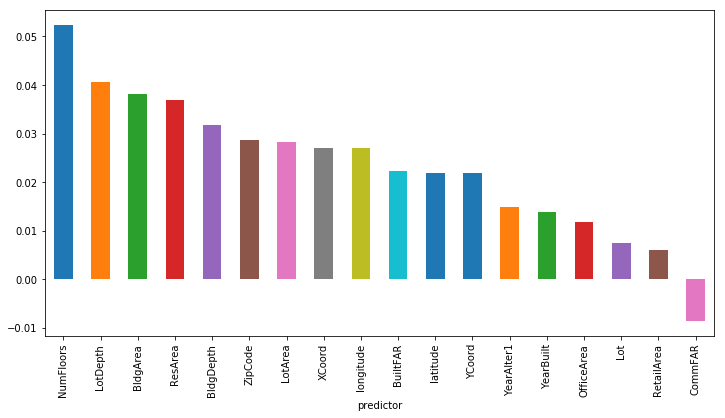

In [17]:
df_correlations.sort_values('Pearson correlation', ascending=False)['Pearson correlation'].plot.bar (figsize=(12, 6))

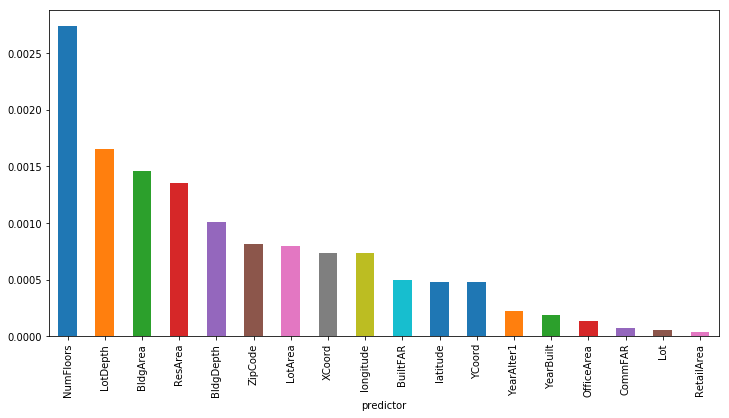

In [18]:
df_correlations['r squared'] = df_correlations['Pearson correlation']**2

df_correlations.sort_values('r squared', ascending=False)['r squared'].plot.bar (figsize=(12, 6))

### Resulting in:

1. NumFloors (+)
2. LotDepth (+)
3. BldgArea (+)
4. RestArea (+)